In [48]:
import sys
import pprint
import numpy
import cv2
import imutils
from sklearn.cluster import KMeans
from collections import Counter
from matplotlib import pyplot


In [49]:
class FaceCropper(object):

    #CASCADE_PATH = "data/haarcascades/haarcascade_frontalface_default.xml"
    #CASCADE_PATH = "data/haarcascades/haarcascade_frontalface_alt.xml"
    #CASCADE_PATH = "data/haarcascades/haarcascade_frontalface_alt2.xml"
    CASCADE_PATH = "data/lbpcascades/lbpcascade_frontalface.xml"
    #CASCADE_PATH = "data/lbpcascades/lbpcascade_frontalface_improved.xml"

    def __init__(self):

        self.face_cascade = cv2.CascadeClassifier(self.CASCADE_PATH)

    def generate(self, image_path):

        img1 = cv2.imread(image_path)

        if (img1 is None):
            img2 = imutils.url_to_image(image_path)
            if (img2 is None):
                print("Can't open image file")
                return 0
            else:
                img = img2
        else:
            img = img1

        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(img, 1.1, 5, minSize=(100, 100))

        if (faces is None):
            print('Failed to detect face')
            return 0

        '''pyplot.figure(0)
        pyplot.subplot(1, 3, 1)
        pyplot.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        pyplot.title("Original Image")''';
        #pyplot.show()
    
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x,y), (x+w, y+h), (255,225,225), 2)
        
        cv2.imshow('img', img)
        cv2.waitKey(1)
        cv2.destroyAllWindows()

        #facecount = len(faces)
        #print("Detected faces: %d" % facecount)
        #height, width = img.shape[:2]
        
        i = 0

        for (x, y, w, h) in faces:

            r = max(w, h) / 2
            centerx = x + w / 2
            centery = y + h / 2
            nx = int(centerx - r)
            ny = int(centery - r)
            nr = int(r * 2)

            faceimg = img[ny:ny+nr, nx:nx+nr]
            lastimg = cv2.resize(faceimg, (300, 300))
            #image = imutils.resize(image, width = 300)
            
            cv2.imwrite("%d.jpg" % i, lastimg)
            i += 1

            
def extractSkin(image):

    # Taking a copy of the image
    img = image.copy()

    # Converting from BGR Colours Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = numpy.array([0, 48, 80], dtype=numpy.uint8)
    
    upper_threshold = numpy.array([20, 255, 255], dtype=numpy.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)


def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            
            # delete the occurance
            del occurance_counter[x[0]]
            
            # remove the cluster
            hasBlack = True
            estimator_cluster = numpy.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)


def getColorInformation(estimator_labels, estimator_cluster, hasThresholding = False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove the black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack) & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1] * 100 / totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color, "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation


def extractDominantColor(image, number_of_colors = 5, hasThresholding = False):

    # Quick Fix Increase cluster counter to neglect the black
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation


def plotColorBar(colorInformation):

    # Create a 500x100 black image
    color_bar = numpy.zeros((100, 500, 3), dtype="uint8")

    top_x = 0

    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1] / 100)

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x

    return color_bar


def p_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()


https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse3.mm.bing.net%2Fth%3Fid%3DOIP.qnyOKC5RGoIQYW9D7MNrZgHaE8%26pid%3DApi&f=1


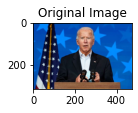

In [50]:
if __name__ == '__main__':
    
    '''args = sys.argv

    if (len(args) != 2):
        print('Use: python %s [image file location or double quoted image url here]' % args[0])
        quit()

    detecter = FaceCropper()
    detecter.generate(args[1])''';
    
# If you are using JupyterNotebook, comment above 6 lines and decomment below 2 lines with ''' and ; as shown
# If you are using cmdPrompt/PowerShell, decomment above 6 lines and comment below 2 lines with ''' and ; as shown
    
    detecter = FaceCropper()
    detecter.generate(input())
    

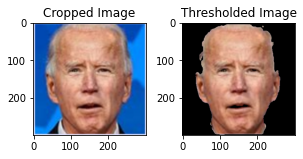

In [51]:
# Reading Cropped Image
image = cv2.imread("0.jpg")


# Show Cropped Image
'''pyplot.subplot(1, 3, 2)
pyplot.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
pyplot.title("Cropped Image")''';
#pyplot.show()


# Resize image to a width of 300 & Apply Skin Mask
skin = extractSkin(cv2.resize(image, (300, 300)))


# Show Skin Mask
'''pyplot.subplot(1, 3, 3)
pyplot.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
pyplot.title("Thresholded Image")
pyplot.tight_layout()''';
#pyplot.show()


In [52]:
# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors = N' where N is the specified number of colors, hasThresholding = True ignores black
dominantColors = extractDominantColor(skin, number_of_colors = 4, hasThresholding = True)


# Show in the dominant color information
'''print("Color Information")
p_print_data(dominantColors)
print()''';


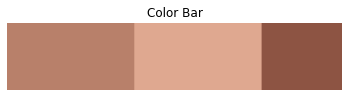

In [53]:
# Show in the dominant color as bar
#print("Color Bar")
color_bar = plotColorBar(dominantColors)
pyplot.figure(1)
pyplot.subplot(1, 1, 1)
pyplot.axis("off")
pyplot.imshow(color_bar)
pyplot.title("Color Bar")


#Show all plots plotted
pyplot.show()
